In [1]:
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(350)

In [2]:
def plot_time(data, sampling_rate, log=True, log_prefix=20, *args, **kwargs):
    n_samples = data.shape[-1]
    times = np.arange(n_samples)/sampling_rate
    if log:
        data_db = log_prefix*np.log10(np.abs(data))
        plt.plot(times, data_db.T, *args, **kwargs)
        max_db = np.nanmax(data_db)
        ax = plt.gca()
        ax.set_ylim((max_db-80+5, max_db+5))
        ax.set_ylabel('Amplitude [dB re 1]')
    else:
        plt.plot(times, data.T, *args, **kwargs)
        ax.set_ylabel('Amplitude [re 1]')
        
    ax.set_xlabel('Time [s]')
    plt.grid(True)
    plt.legend()

# Room Acoustics Toolbox in Python
The Room Acoustics Toolbox in Python is a collection of functions for commonly used calculcations in room acoustics.
## Getting Started
In this notebook, the most relevant functions of the toolbox are outlined.
### 1 Generate an Analytic Room Impulse Response
In the following it is outlined, how the transfer function of a rectangular room based on the analytic model [1] can be generated using the toolbox.

In [3]:
from roomacoustics import analytic

In order to generate an analytic transfer function of a room, the fundamental characteristics of the scenario have to be spectified. The RIR is generated by the function `rectangular_room_rigid_walls(dimensions=..., source=..., receiver=..., reverberation_time=..., max_freq=..., samplingrate=..., speed_of_sound=..., n_samples=...)`, which is part of the `analytic` module.

In [4]:
sampling_rate = 44100
room_dimensions = [3, 2, 2]
src_pos = [0.33, 1.55, 1]
rec_pos = [2.21, 0.34, 1.2]
t_60 = 2
max_freq = 1000
n_samples = 2**18
speed_of_sound = 343.9

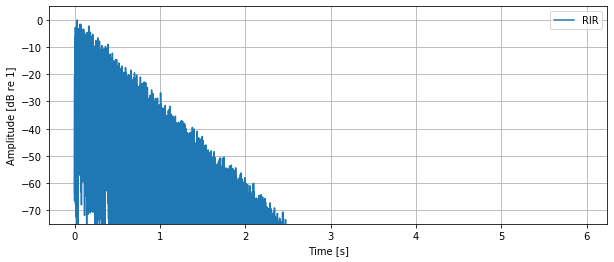

In [5]:
rir_1 = analytic.rectangular_room_rigid_walls(
    dimensions=room_dimensions, source=src_pos, receiver=rec_pos, reverberation_time=t_60, max_freq=max_freq,
    samplingrate=sampling_rate, speed_of_sound=speed_of_sound, n_samples=n_samples)[0]

rir_1 /= np.amax(np.abs(rir_1)) # Normalize 
time_vector = np.arange(0, n_samples) / sampling_rate

# Plot the result:
plt.figure(figsize=(10, 4))
plot_time(rir_1, sampling_rate, label='RIR')

### 2 Introducing Noise
In order to demonstrate the provided energy decay curve noise handling methods, it is necessary to introduce some Gaussian noise on the channel.

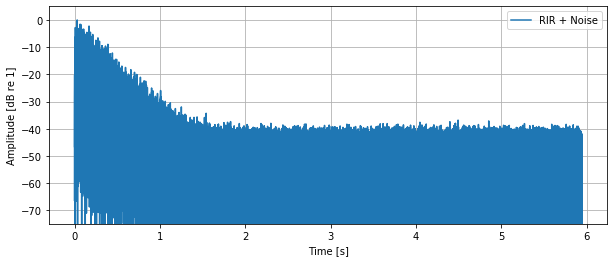

In [6]:
psnr = 50
rir_1_noise = rir_1.copy() + 10**(-(psnr) / 20) * np.random.normal(0,1,rir_1.size)

plt.figure(figsize=(10, 4))
plot_time(rir_1_noise, sampling_rate, label='RIR + Noise')

### 3 Estimate the Noise Energy of a RIR
The `edc_noise_handling` module provides various methods for noise compensation of room impulse responses. 

In [7]:
import roomacoustics as ra

The interval can be chosen as percentages of the RIR. The estimation interval `interval=[0.9, 1.0]` corresponds to the last 10% of the RIR.

In [8]:
interval = [0.9, 1.]

The estimated noise level is at [-49.97964389] dB.


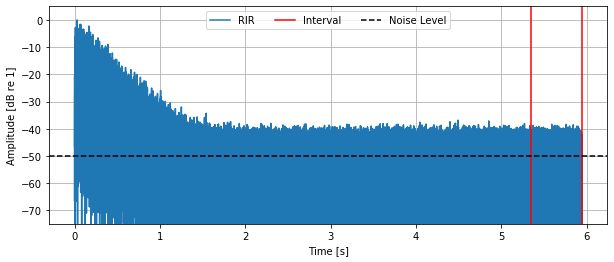

In [9]:
plt.figure(figsize=(10, 4))
plot_time(rir_1_noise, sampling_rate, label='RIR')
plt.axvline(time_vector[-1]*interval[0], color='red', label='Interval')
plt.axvline(time_vector[-1]*interval[1], color='red')

noise_energy = ra.estimate_noise_energy(
    rir_1_noise, interval=interval, is_energy=False)

noise_energy_db = 10*np.log10(noise_energy)
plt.axhline(noise_energy_db, color='k', linestyle='--', label='Noise Level')

plt.legend(loc='upper center', ncol=3)

output_string = "The estimated noise level is at {} dB.".format(noise_energy_db)
print(output_string)

### 4 EDC Noise Compensation

The functions regarding EDC noise compensation always accept the following parameters. The examples below always utilize the default parameters, e.g. a time shift is performed.
```
Parameters
----------
data : ndarray, double
    The room impulse response with dimension [..., n_samples]
sampling_rate: integer
    The sampling rate of the room impulse response.
freq: integer OR string
    The frequency band. If set to 'broadband',
    the time window of the Lundeby-algorithm will not be set in dependence
    of frequency.
noise_level: ndarray, double OR string
    If not specified, the noise level is calculated based on the last 10
    percent of the RIR. Otherwise specify manually for each channel
    as array.
is_energy: boolean
    Defines, if the data is already squared.
time_shift : boolean
    Defines, if the silence at beginning of the RIR should be removed.
channel_independent : boolean
    Defines, if the time shift and normalizsation is done
    channel-independently or not.
normalize : boolean
    Defines, if the energy decay curve should be normalized in the end
    or not.
plot: Boolean
    Specifies, whether the results should be visualized or not.

Returns
-------
energy_decay_curve: ndarray, double
    Returns the noise handeled edc.
```
#### 4.1 Full Impulse Response
When considering the full room impulse response for the EDC calculation, the plot below shows that the noise in the RIR introduces an error in the estimated EDC.

$$ E_{\mathrm{Full}}(t) = \int_t^{t_{IR}} h^2(\tau) d\tau  $$

$E(t)$ denotes the energy decay curve, $t$ the time, $t_{IR}$ the length of the impulse response and $h(\tau)$ the impulse response.



In [10]:
rir_noise_shifted = ra.preprocess_rir(rir_1_noise, time_shift=True)[0]
10*np.log10(np.abs(ra.estimate_noise_energy(rir_noise_shifted, is_energy=True)))

array([-49.97975893])

The estimated noise level is at [-49.97975893] dB.


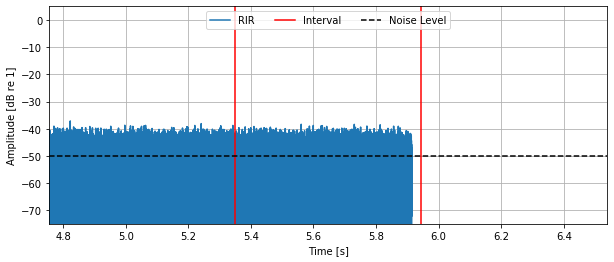

In [11]:
plt.figure(figsize=(10, 4))
plot_time(rir_noise_shifted, sampling_rate, log_prefix=10, label='RIR')
plt.axvline(time_vector[-1]*interval[0], color='red', label='Interval')
plt.axvline(time_vector[-1]*interval[1], color='red')


noise_energy = ra.estimate_noise_energy(
    rir_noise_shifted, interval=interval, is_energy=True)

noise_energy_db = 10*np.log10(noise_energy)
plt.axhline(noise_energy_db, color='k', linestyle='--', label='Noise Level')
plt.xlim(0.8*np.max(time_vector), 1.1*np.max(time_vector), )

plt.legend(loc='upper center', ncol=3)

output_string = "The estimated noise level is at {} dB.".format(noise_energy_db)
print(output_string)

(-60, 5.0)

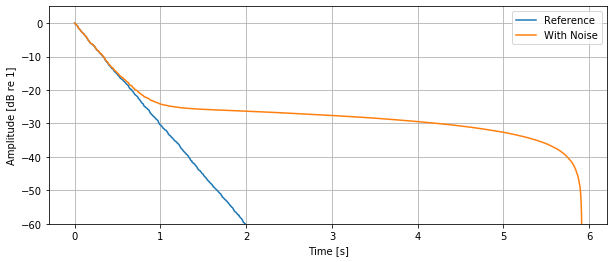

In [12]:
rir_noise_shifted = ra.preprocess_rir(rir_1_noise, time_shift=True)[0]
edc_full_rir = ra.schroeder_integration(np.squeeze(rir_noise_shifted), is_energy=True)
rir_shifted = ra.preprocess_rir(rir_1, time_shift=True)[0]
edc_full_rir_compare = ra.schroeder_integration(np.squeeze(rir_shifted), is_energy=True)
edc_full_rir /= edc_full_rir[0]
edc_full_rir_compare /= edc_full_rir_compare[0]

plt.figure(figsize=(10, 4))
plot_time(edc_full_rir_compare, sampling_rate, log_prefix=10, label='Reference')
plot_time(edc_full_rir, sampling_rate, log_prefix=10, label='With Noise')
plt.ylim(-60)

In [13]:
from roomacoustics import dsp
np.broadcast_to(-dsp.find_impulse_response_start(rir_1), 1)

array([-1349], dtype=int64)

#### 4.2 Truncation

The RIR can be truncated to the intersection time $t_i$, where the decaying impulse response intersects with the estimated noise floor. The estimation of the intersection time after Lundeby et al. [2] is visualized below.

$$ E_\mathrm{Trunc}(t) = \int_t^{t_{i}} h^2(\tau) d\tau  $$

The estimated intersection time is [1.34317931]s, the late reverberation time is [1.98377279]s and the estimated noise is [-49.96369523]dB.


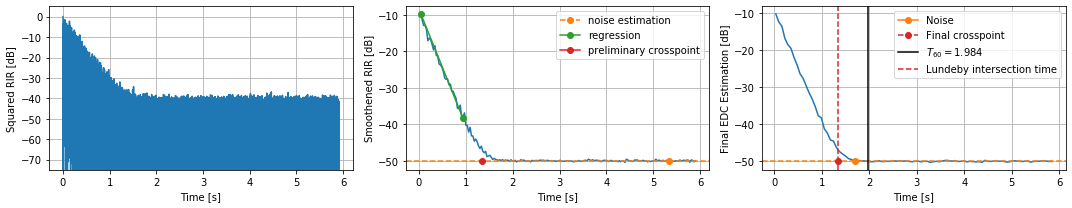

In [14]:
intersection_time, late_reveberation_time, noise_level_lundeby = \
    ra.intersection_time_lundeby(
        rir_1_noise, sampling_rate=sampling_rate, freq='broadband', is_energy=False,
        time_shift=True, channel_independent=False, plot=True)

output_string = "The estimated intersection time is {}s, the late reverberation time is {}s and the estimated noise is {}dB.".format(intersection_time, late_reveberation_time, 10*np.log10(np.abs(noise_level_lundeby)))
print(output_string)

The next plot shows, how the noise error reduces significantly if the truncated RIR is utilized.

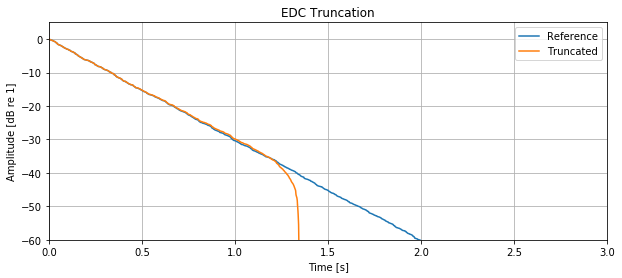

In [15]:
edc_truncation = ra.energy_decay_curve_truncation(
        rir_1_noise, sampling_rate, freq='broadband', is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

plt.figure(figsize=(10, 4))
plot_time(edc_full_rir_compare, sampling_rate, log_prefix=10, label='Reference')
plot_time(edc_truncation, sampling_rate, log_prefix=10, label='Truncated')
plt.ylim(-60);
plt.xlim(0, 3)
plt.title("EDC Truncation");

#### 4.3 Chu's Method

Chu [3] proposed a noise compensation method, where the noise energy is subtracted from the RIR in advance. This yields a even more noise compensated EDC.

$$ E(t)_\mathrm{Chu} = \int_t^{t_{IR}} (h^2(\tau) - N_{est}^2) d\tau  $$

In [16]:
edc_chu_auto = ra.energy_decay_curve_chu(
        rir_1_noise, sampling_rate, freq='broadband', noise_level='auto', is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

In [17]:
noise_level_man = ra.estimate_noise_energy(rir_1_noise, interval=[0.6, 1.0], is_energy=False)
edc_chu_man = ra.energy_decay_curve_chu(
        rir_1_noise, sampling_rate, freq='broadband', noise_level=noise_level_man, is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

In [18]:
edc_chu_noise_lundeby = ra.energy_decay_curve_chu(
        rir_1_noise, sampling_rate, freq='broadband', noise_level=noise_level_lundeby, is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

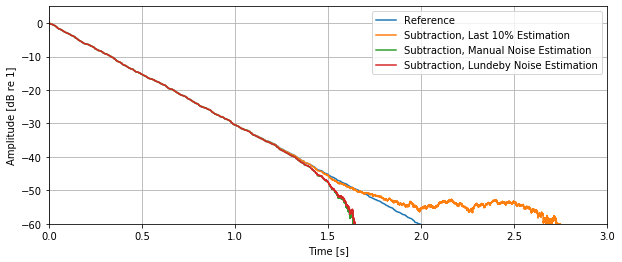

In [19]:
plt.figure(figsize=(10, 4))
plot_time(edc_full_rir_compare, sampling_rate, log_prefix=10, label='Reference')
plot_time(edc_chu_auto, sampling_rate, log_prefix=10, label='Subtraction, Last 10% Estimation')
plot_time(edc_chu_man, sampling_rate, log_prefix=10, label='Subtraction, Manual Noise Estimation')
plot_time(edc_chu_noise_lundeby, sampling_rate, log_prefix=10, label='Subtraction, Lundeby Noise Estimation')
plt.ylim(-60)
plt.xlim(0, 3);

#### 4.4 Lundeby's Method

Lundeby et al. [2] proposed a noise compensation method, where the RIR is truncated to the intersection time and additionally intruced a correction term $C_\mathrm{Comp}$.

$$ E_\mathrm{Lundeby}(t) = \int_t^{t_i} h^2(\tau) d\tau + C_\mathrm{Comp}  $$

$$C_\mathrm{Comp} = p_{i}^2 \cdot T_{60, late} \cdot \frac{1}{6 \cdot ln(10)} \cdot R_s $$

$p_{i}^2$ denotes the squared sound pressure at the intersection time, $T_{60, late}$ the late reverberation time after Lundeby and $R_s$ the sampling rate.

TO-DO: Reference for correction term

(0, 3)

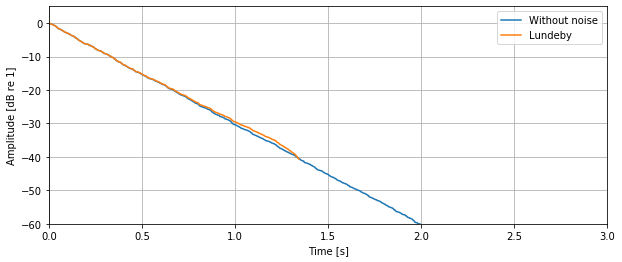

In [20]:
edc_lundeby = ra.energy_decay_curve_lundeby(
        rir_1_noise, sampling_rate, freq='broadband', is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

plt.figure(figsize=(10, 4))
plot_time(edc_full_rir_compare, sampling_rate, log_prefix=10, label='Without noise')
plot_time(edc_lundeby, sampling_rate, log_prefix=10, label='Lundeby')
plt.ylim(-60)
plt.xlim(0,3)

#### 4.5 Lundeby and Chu Combined

When combining all methods, the influence of the noise can be minimized [4].

$$ E_\mathrm{Chu, Lundeby}(t) = \int_t^{t_i} (h^2(\tau) - N_{est}^2) d\tau + C_\mathrm{Comp}  $$

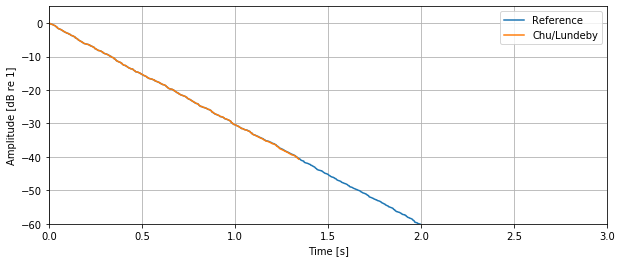

In [21]:
edc_chu_lundeby = ra.energy_decay_curve_chu_lundeby(
        rir_1_noise, sampling_rate, freq='broadband', is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

plt.figure(figsize=(10, 4))
plot_time(edc_full_rir_compare, sampling_rate, log_prefix=10, label='Reference')
plot_time(edc_chu_lundeby, sampling_rate, log_prefix=10, label='Chu/Lundeby')
plt.ylim(-60)
plt.xlim(0,3);

#### 4.6 Comparison of All Noise Compensation Methods

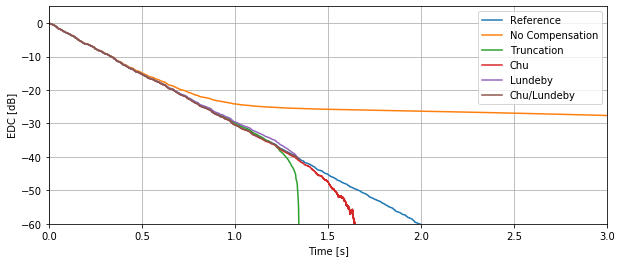

In [22]:
plt.figure(figsize=(10, 4))
plot_time(edc_full_rir_compare, sampling_rate, log_prefix=10, label='Reference')
plot_time(edc_full_rir, sampling_rate, log_prefix=10, label='No Compensation')
plot_time(edc_truncation, sampling_rate, log_prefix=10, label='Truncation')
plot_time(edc_chu_noise_lundeby, sampling_rate, log_prefix=10, label='Chu')
plot_time(edc_lundeby, sampling_rate, log_prefix=10, label='Lundeby')
plot_time(edc_chu_lundeby, sampling_rate, log_prefix=10, label='Chu/Lundeby')
plt.xlabel('Time [s]')
plt.ylabel('EDC [dB]')
plt.ylim(-60)
plt.xlim(0,3);

In [23]:
Tx = 'T30'

edcs = [edc_full_rir_compare, edc_truncation, edc_chu_auto, edc_lundeby, edc_chu_lundeby]
reverberation_times = np.zeros(len(edcs))
for idx, edc in enumerate(edcs):
    mask = np.isnan(edc)
    times = np.arange(0, edc.shape[-1])/sampling_rate
    reverberation_times[idx] = \
        ra.reverberation_time_energy_decay_curve(
            np.squeeze(edc[~mask]), times[~mask], T=Tx)

Text(0, 0.5, 'T30 [s]')

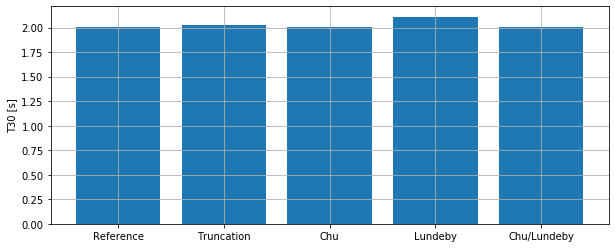

In [24]:
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(reverberation_times)), reverberation_times)
plt.grid(True)
ax = plt.gca()
ax.set_xticklabels(['', 'Reference', 'Truncation', 'Chu', 'Lundeby', 'Chu/Lundeby']);
ax.set_ylabel(Tx + ' [s]')

## References
[1] H. Kuttruff, Room acoustics, pp. 64-66, 4th Ed. Taylor & Francis, 2009.

[2] Lundeby, Virgran, Bietz and Vorlaender - Uncertainties of Measurements in Room Acoustics - ACUSTICA Vol. 81 (1995)

[3] W. T. Chu. “Comparison of reverberation measurements using Schroeder’s impulse method and decay-curve averaging method”. In: Journal of the Acoustical Society of America 63.5 (1978), pp. 1444–1450.

[4] M. Guski, “Influences of external error sources on measurements of room acoustic parameters,” 2015.
